In [268]:
import pandas as pd
import kaggle
import os
import warnings
import zipfile
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split , GridSearchCV
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('bmh')
import warnings
warnings.filterwarnings("ignore")
import tqdm
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor



In [4]:
!kaggle competitions download -c house-prices-advanced-regression-techniques


  0%|          | 0.00/199k [00:00<?, ?B/s]
100%|██████████| 199k/199k [00:00<00:00, 283kB/s]
100%|██████████| 199k/199k [00:00<00:00, 272kB/s]


In [8]:
zip_file = 'house-prices-advanced-regression-techniques.zip'
destination_folder = 'unzipped_data' 

if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

print('Dataset unzipped successfully!')

Dataset unzipped successfully!


In [143]:
pwd

'z:\\MTE00\\MTE40\\80204_Pongsakorn Thuegtowsan\\MyJob'

In [144]:
train = pd.read_csv('unzipped_data/train.csv')
test = pd.read_csv('unzipped_data/test.csv')

In [198]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [145]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [200]:
df2 = train[[column for column in df if df[column].count() / len(df) >= 0.3]]
del df2['Id']
print("delete col:", end=" ")
for c in train.columns:
    if c not in df2.columns:
        print(c, end=", ")
print('\n')

delete col: Id, Alley, PoolQC, Fence, MiscFeature, 



In [201]:
df = df2

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


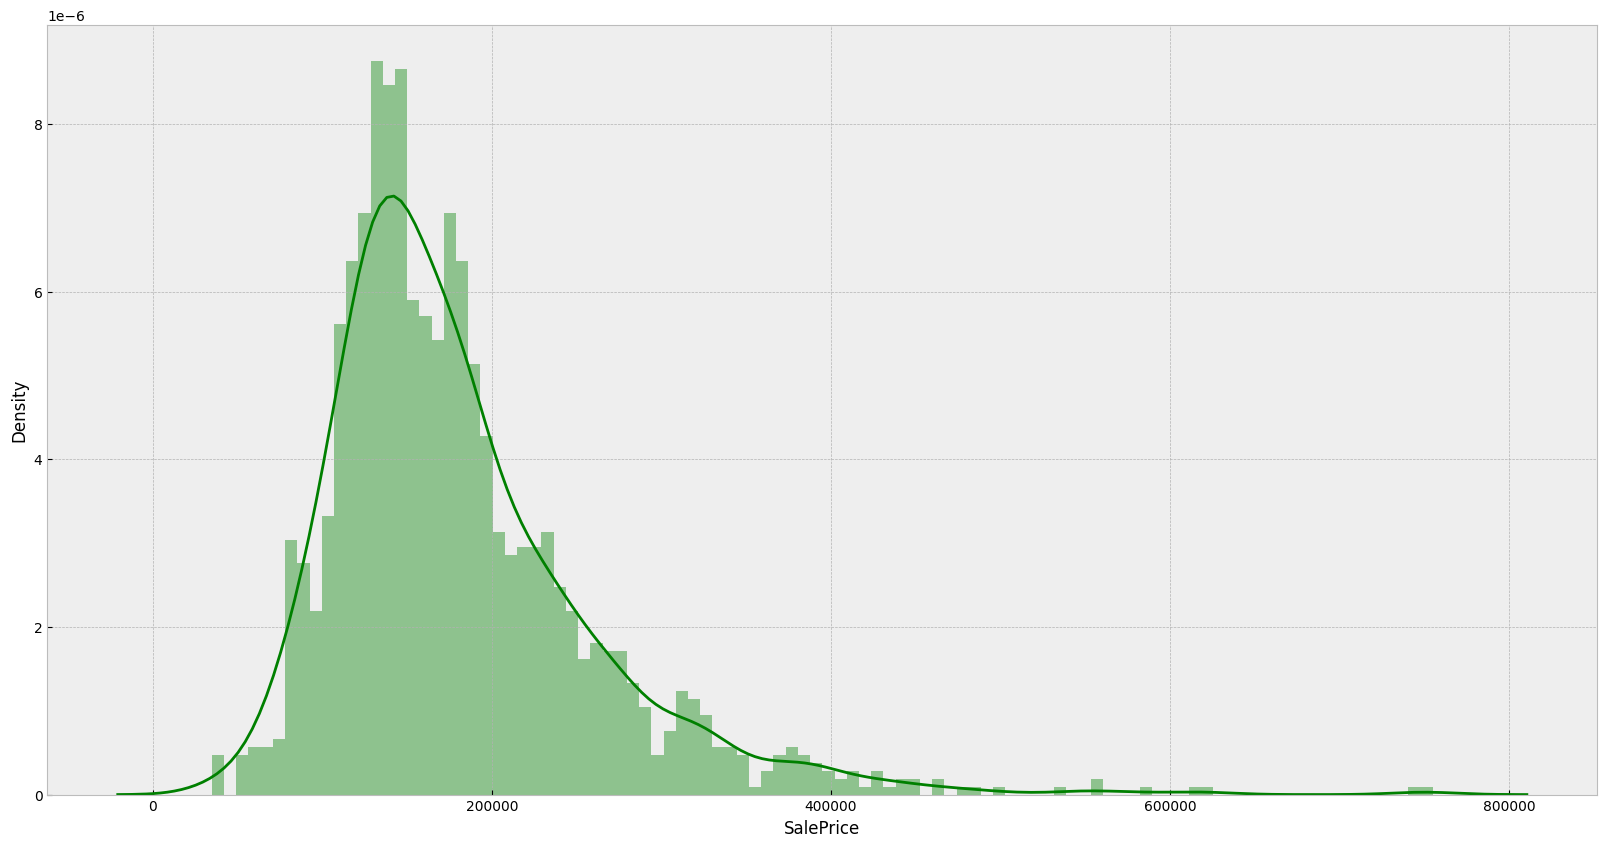

In [202]:
print(df['SalePrice'].describe())
plt.figure(figsize=(20, 10))
sns.distplot(df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});

In [203]:
list(set(df.dtypes.tolist()))

[dtype('O'), dtype('float64'), dtype('int64')]

In [204]:
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


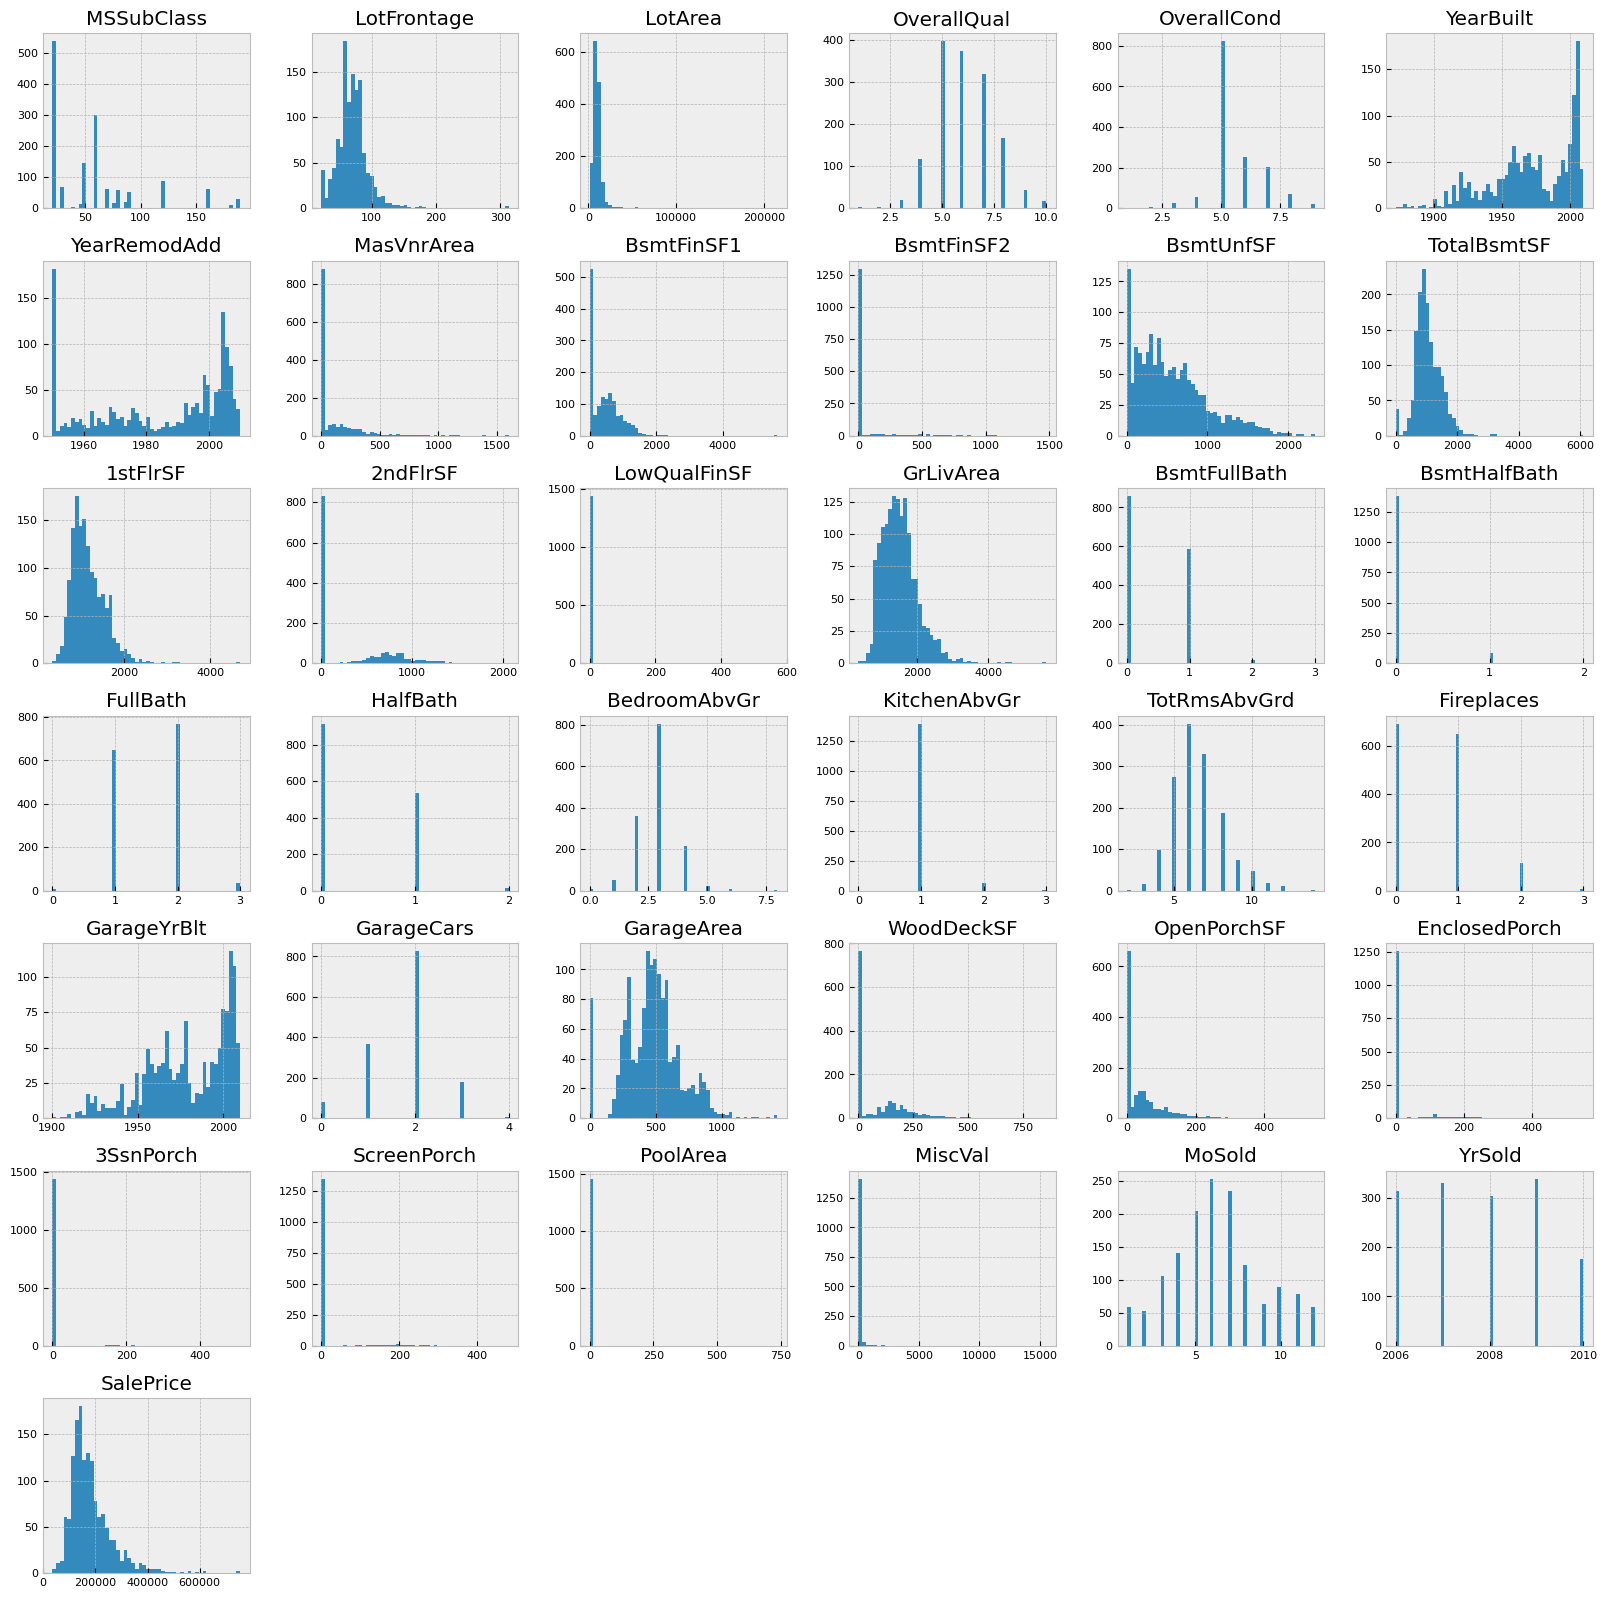

In [205]:
df_num.hist(figsize=(20, 20), bins=50, xlabelsize=8, ylabelsize=8);

Features like 1stFlrSF, TotalBsmtSF, LotFrontage, GrLiveArea... seem to share a distribution similar to what we have with SalePrice.

In [206]:
df_num_corr = df_num.corr()['SalePrice'][:-1]

In [210]:
golden_features_list = df_num_corr[abs(df_num_corr) > 0.4].sort_values(ascending=False)
print("Column   {} Correlation:\n{}".format(len(golden_features_list), golden_features_list))

Column   13 Correlation:
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
GarageYrBlt     0.486362
MasVnrArea      0.477493
Fireplaces      0.466929
Name: SalePrice, dtype: float64


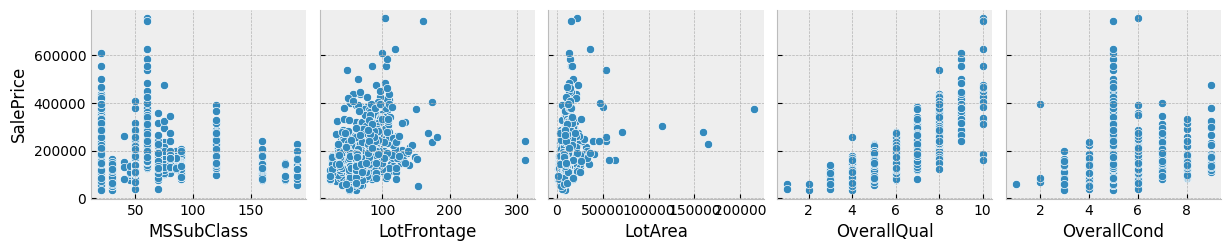

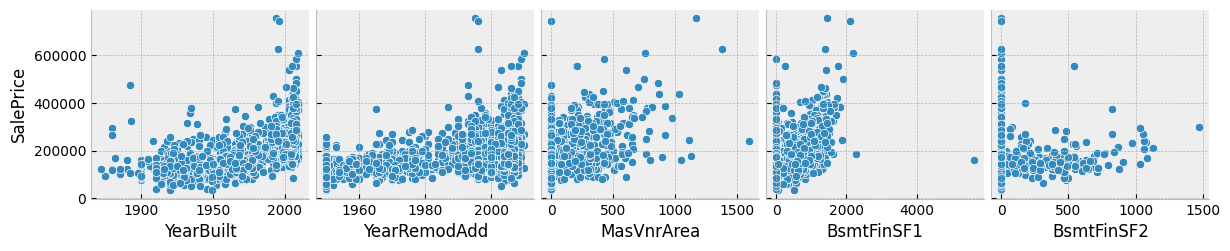

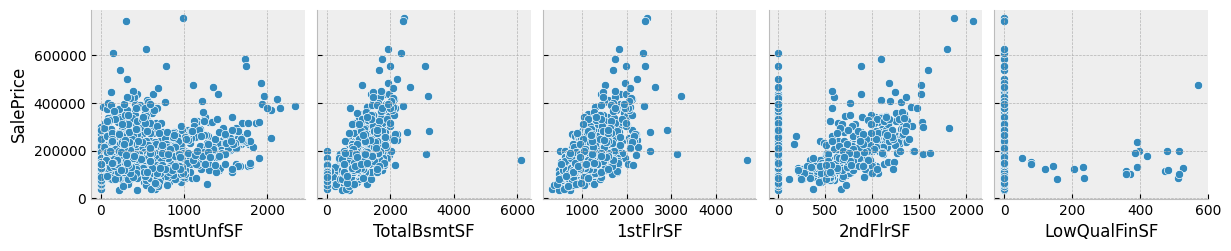

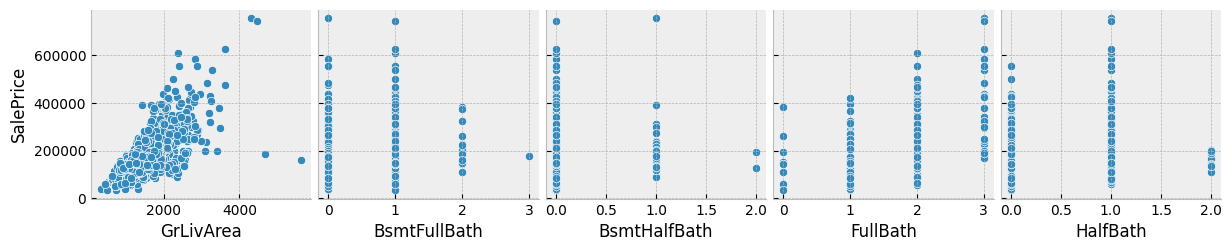

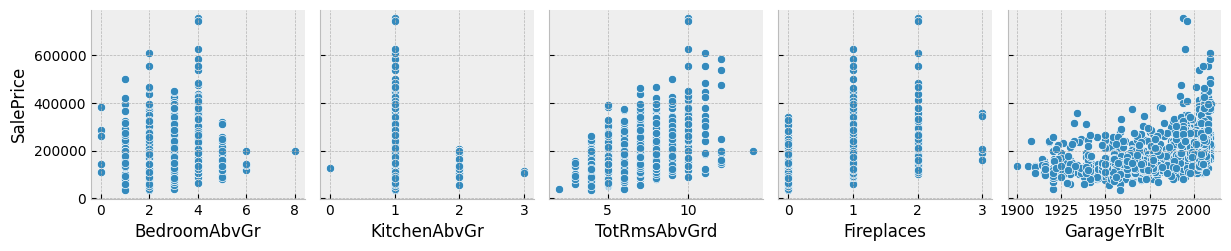

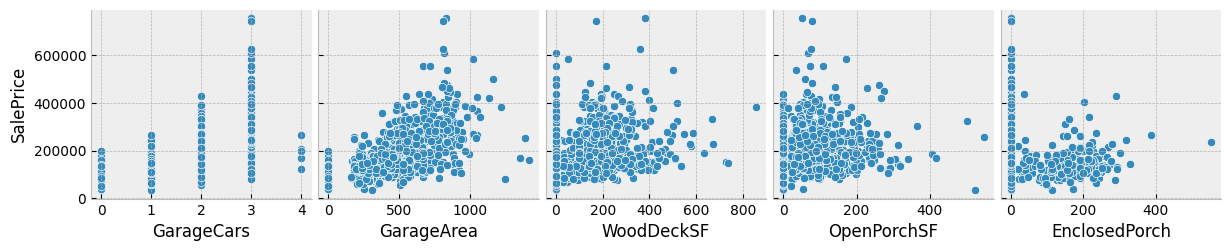

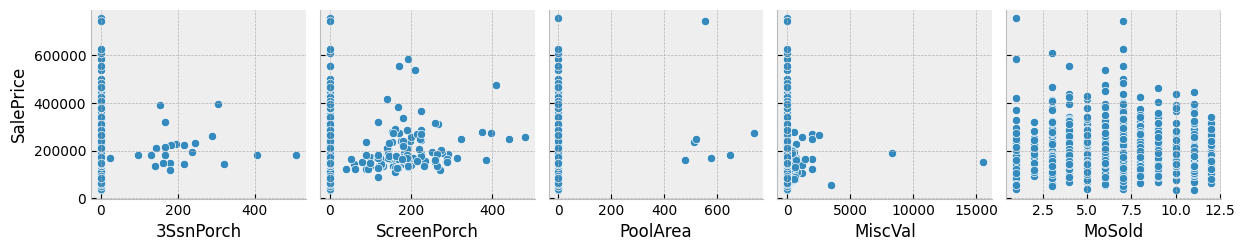

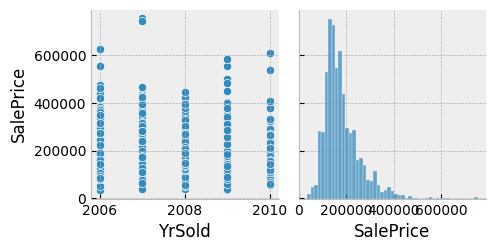

In [211]:
for i in range(0, len(df_num.columns), 5):
    sns.pairplot(data=df_num,
                x_vars=df_num.columns[i:i+5],
                y_vars=['SalePrice'])

In [212]:
import operator

In [213]:
individual_features_df = []
for i in range(0, len(df_num.columns) - 1):
    tmpDf = df_num[[df_num.columns[i], 'SalePrice']]
    tmpDf = tmpDf[tmpDf[df_num.columns[i]] != 0]
    individual_features_df.append(tmpDf)

In [ ]:
individual_features_df

In [215]:
all_correlations = {feature.columns[0]: feature.corr()['SalePrice'][0] for feature in individual_features_df}
all_correlations = sorted(all_correlations.items(), key=operator.itemgetter(1))
for (key, value) in all_correlations:
    print("{:>15}: {:>15}".format(key, value))

   KitchenAbvGr: -0.1392006921778576
       HalfBath: -0.08439171127179902
     MSSubClass: -0.08428413512659509
    OverallCond: -0.07785589404867797
         YrSold: -0.028922585168736813
   BsmtHalfBath: -0.02883456718548182
       PoolArea: -0.014091521506356765
   BsmtFullBath: 0.011439163340408606
         MoSold: 0.046432245223819446
      3SsnPorch: 0.06393243256889088
    OpenPorchSF: 0.08645298857147718
        MiscVal: 0.08896338917298921
     Fireplaces: 0.12166058421363891
      BsmtUnfSF: 0.16926100049514173
   BedroomAbvGr: 0.18093669310848806
     WoodDeckSF: 0.1937060123752066
     BsmtFinSF2: 0.19895609430836594
  EnclosedPorch: 0.24127883630117497
    ScreenPorch: 0.2554300795487841
        LotArea: 0.2638433538714051
   LowQualFinSF: 0.30007501655501323
    LotFrontage: 0.35179909657067737
     MasVnrArea: 0.43409021975689227
     BsmtFinSF1: 0.47169042652357296
    GarageYrBlt: 0.4863616774878596
   YearRemodAdd: 0.5071009671113866
      YearBuilt: 0.52289733287949

In [218]:
golden_features_list = [key for key, value in all_correlations if abs(value) >= 0.4]
print("column len{} feature:\n{}".format(len(golden_features_list), golden_features_list))

column len14 feature:
['MasVnrArea', 'BsmtFinSF1', 'GarageYrBlt', 'YearRemodAdd', 'YearBuilt', 'TotRmsAbvGrd', 'FullBath', '1stFlrSF', 'GarageArea', 'TotalBsmtSF', 'GarageCars', '2ndFlrSF', 'GrLivArea', 'OverallQual']


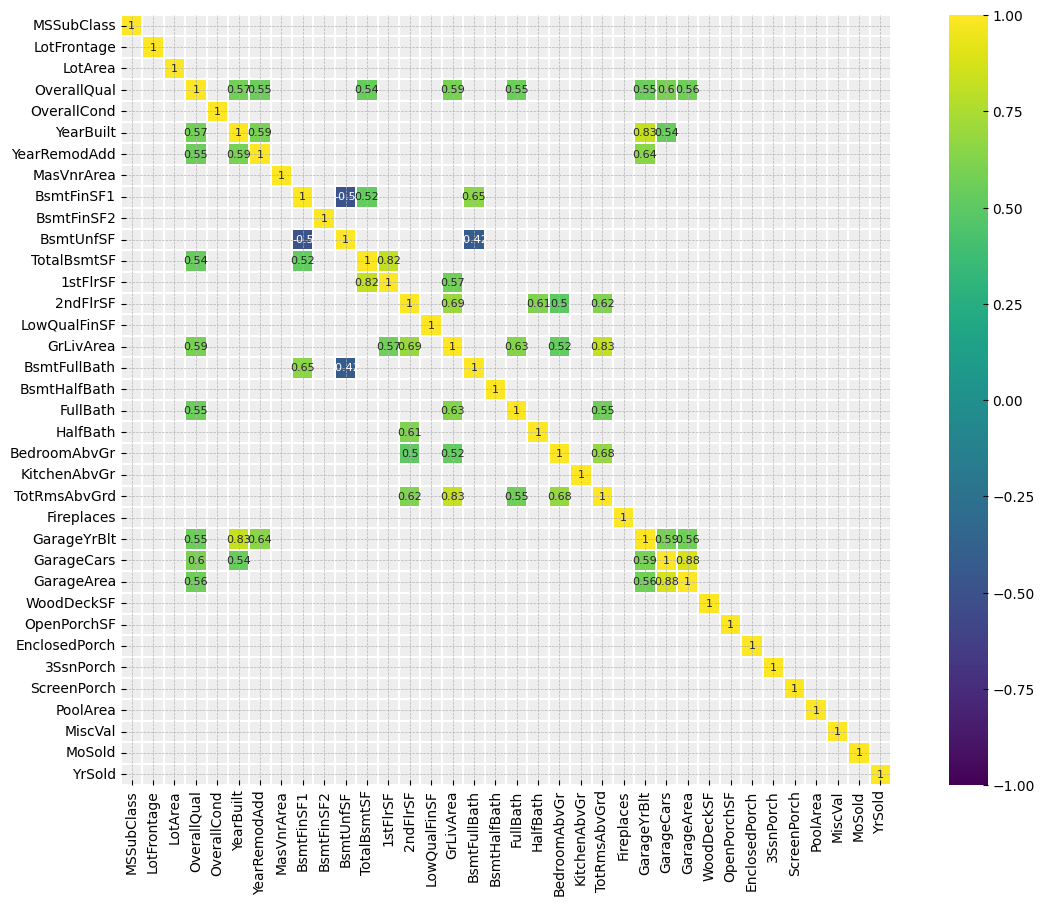

In [219]:
corr = df_num.drop('SalePrice', axis=1).corr() # We already examined SalePrice correlations
plt.figure(figsize=(15, 10))

sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

In [220]:
quantitative_features_list = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', '1stFlrSF',
    '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
    'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 
    'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'SalePrice']

In [221]:
df_quantitative_values = df[quantitative_features_list]

In [223]:
df_quantitative_values.head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,...,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice
0,65.0,8450,196.0,706,0,856,856,854,0,1710,...,2,548,0,61,0,0,0,0,0,208500
1,80.0,9600,0.0,978,0,1262,1262,0,0,1262,...,2,460,298,0,0,0,0,0,0,181500
2,68.0,11250,162.0,486,0,920,920,866,0,1786,...,2,608,0,42,0,0,0,0,0,223500
3,60.0,9550,0.0,216,0,756,961,756,0,1717,...,3,642,0,35,272,0,0,0,0,140000
4,84.0,14260,350.0,655,0,1145,1145,1053,0,2198,...,3,836,192,84,0,0,0,0,0,250000


In [224]:
features_to_analyse = [x for x in quantitative_features_list if x in golden_features_list]

In [225]:
features_to_analyse

['MasVnrArea',
 'BsmtFinSF1',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'GarageCars',
 'GarageArea']

In [226]:
features_to_analyse.append('SalePrice')

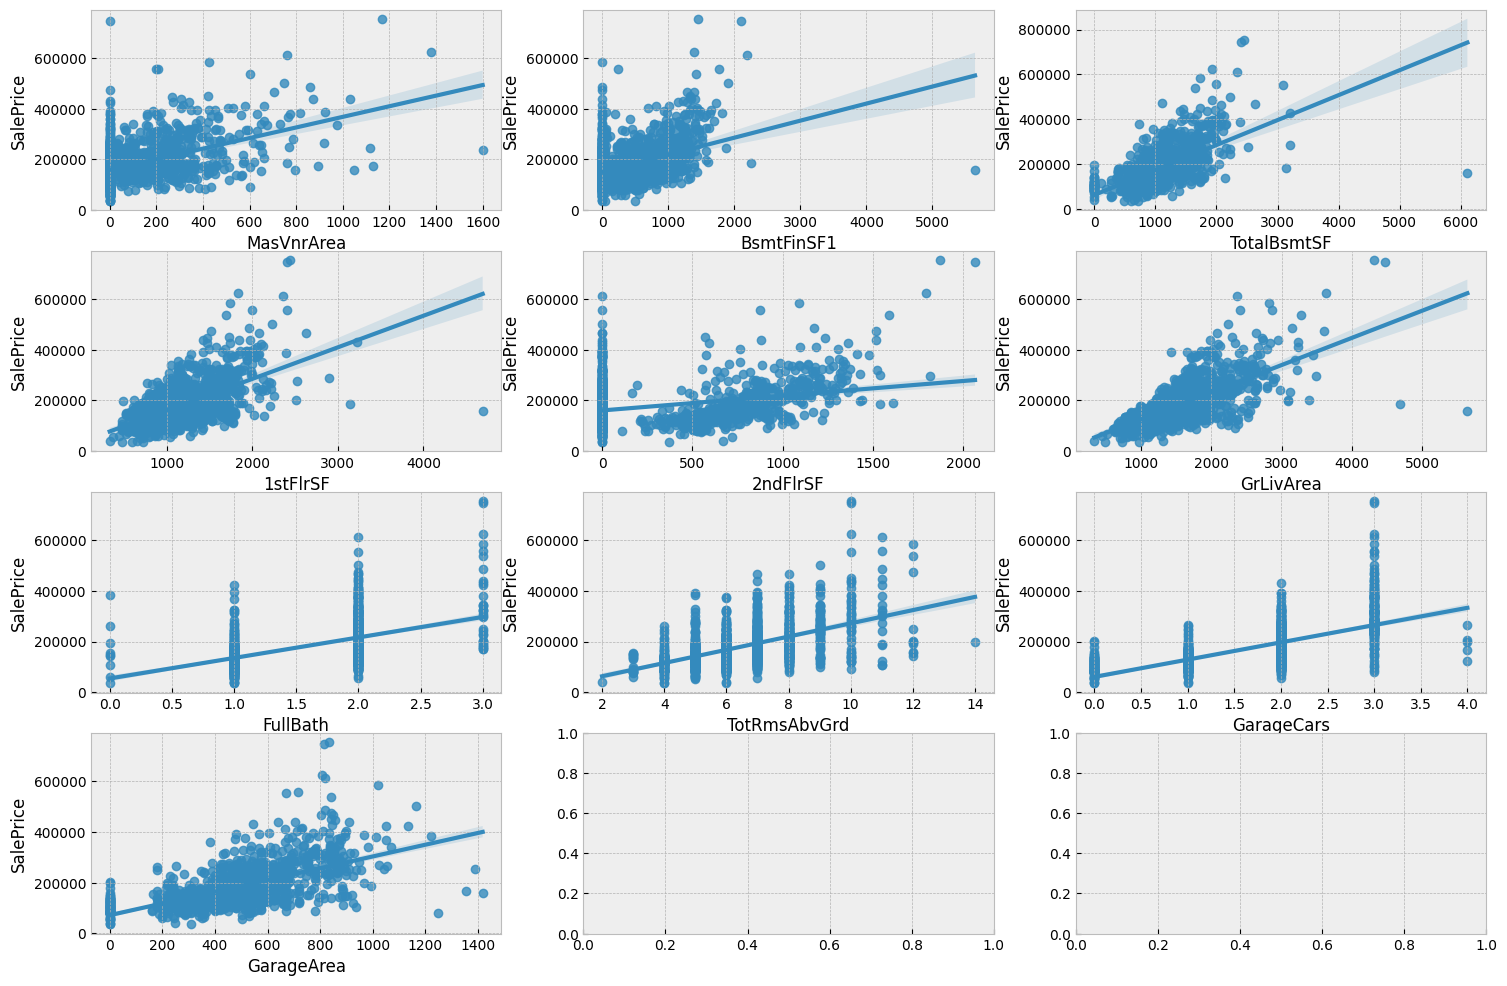

In [227]:
fig, ax = plt.subplots(round(len(features_to_analyse) / 3), 3, figsize = (18, 12))

for i, ax in enumerate(fig.axes):
    if i < len(features_to_analyse) - 1:
        sns.regplot(x=features_to_analyse[i],y='SalePrice', data=df[features_to_analyse], ax=ax)

In [228]:
categorical_features = [a for a in quantitative_features_list[:-1] + df.columns.tolist() if (a not in quantitative_features_list[:-1]) or (a not in df.columns.tolist())]

In [229]:
categorical_features

['MSSubClass',
 'MSZoning',
 'Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtUnfSF',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'MoSold',
 'YrSold',
 'SaleType',
 'SaleCondition',
 'SalePrice']

In [230]:
df_categ = df[categorical_features]
df_categ.head()

,MSSubClass,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageYrBlt,GarageFinish,GarageQual,GarageCond,PavedDrive,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,2003.0,RFn,TA,TA,Y,2,2008,WD,Normal,208500
1,20,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,1976.0,RFn,TA,TA,Y,5,2007,WD,Normal,181500
2,60,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,2001.0,RFn,TA,TA,Y,9,2008,WD,Normal,223500
3,70,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,1998.0,Unf,TA,TA,Y,2,2006,WD,Abnorml,140000
4,60,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,2000.0,RFn,TA,TA,Y,12,2008,WD,Normal,250000


In [231]:
df_not_num = df_categ.select_dtypes(include = ['O'])
print('len df not num {} col name :\n{}'.format(len(df_not_num.columns), df_not_num.columns.tolist()))

len df not num 39 col name :
['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


When we look at these properties, we can see that most of them are of type Object(O). For example, "ExterQual" can be converted to an ordered categorical object

([0, 1, 2, 3],
 [Text(0, 0, 'No'), Text(1, 0, 'Gd'), Text(2, 0, 'Mn'), Text(3, 0, 'Av')])

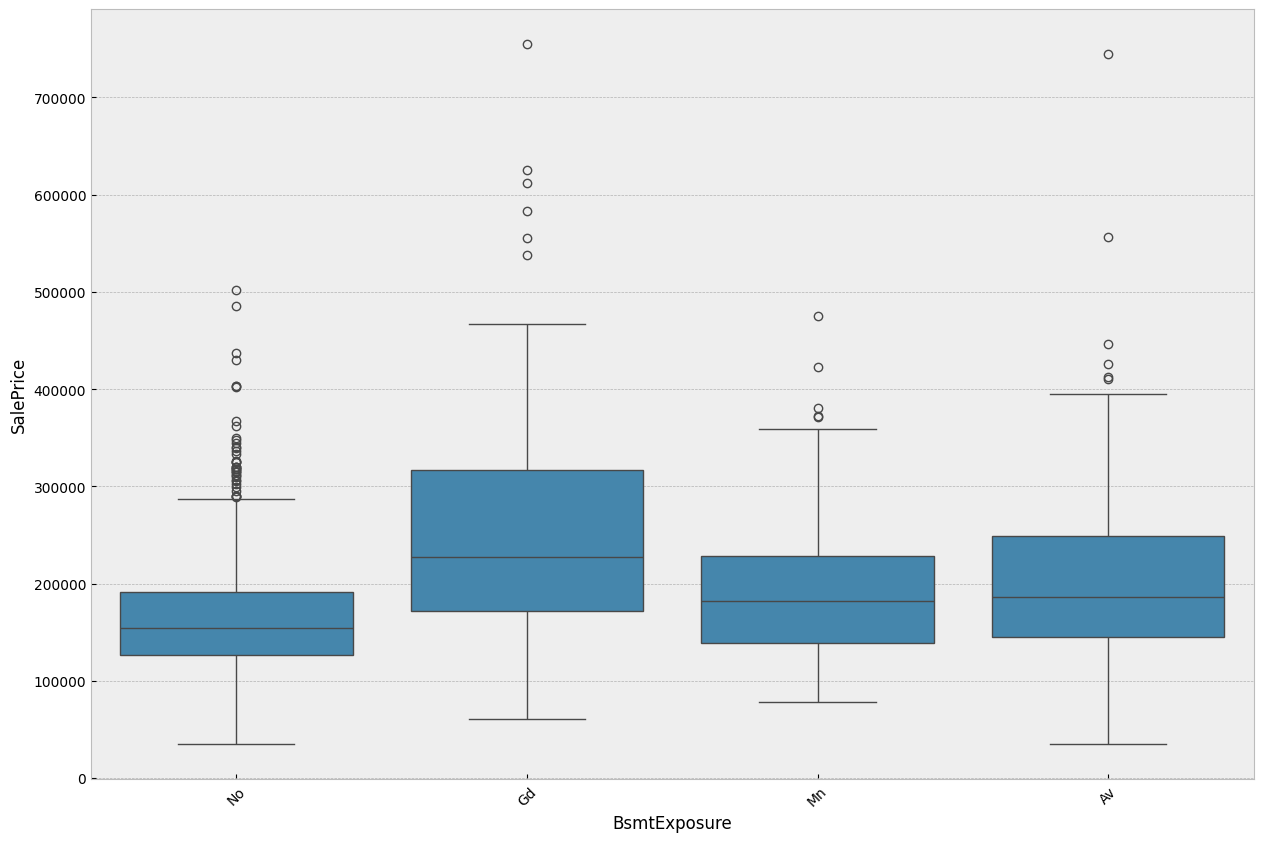

In [232]:
plt.figure(figsize = (15, 10))
ax = sns.boxplot(x='BsmtExposure', y='SalePrice', data=df_categ)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Normal'),
  Text(1, 0, 'Abnorml'),
  Text(2, 0, 'Partial'),
  Text(3, 0, 'AdjLand'),
  Text(4, 0, 'Alloca'),
  Text(5, 0, 'Family')])

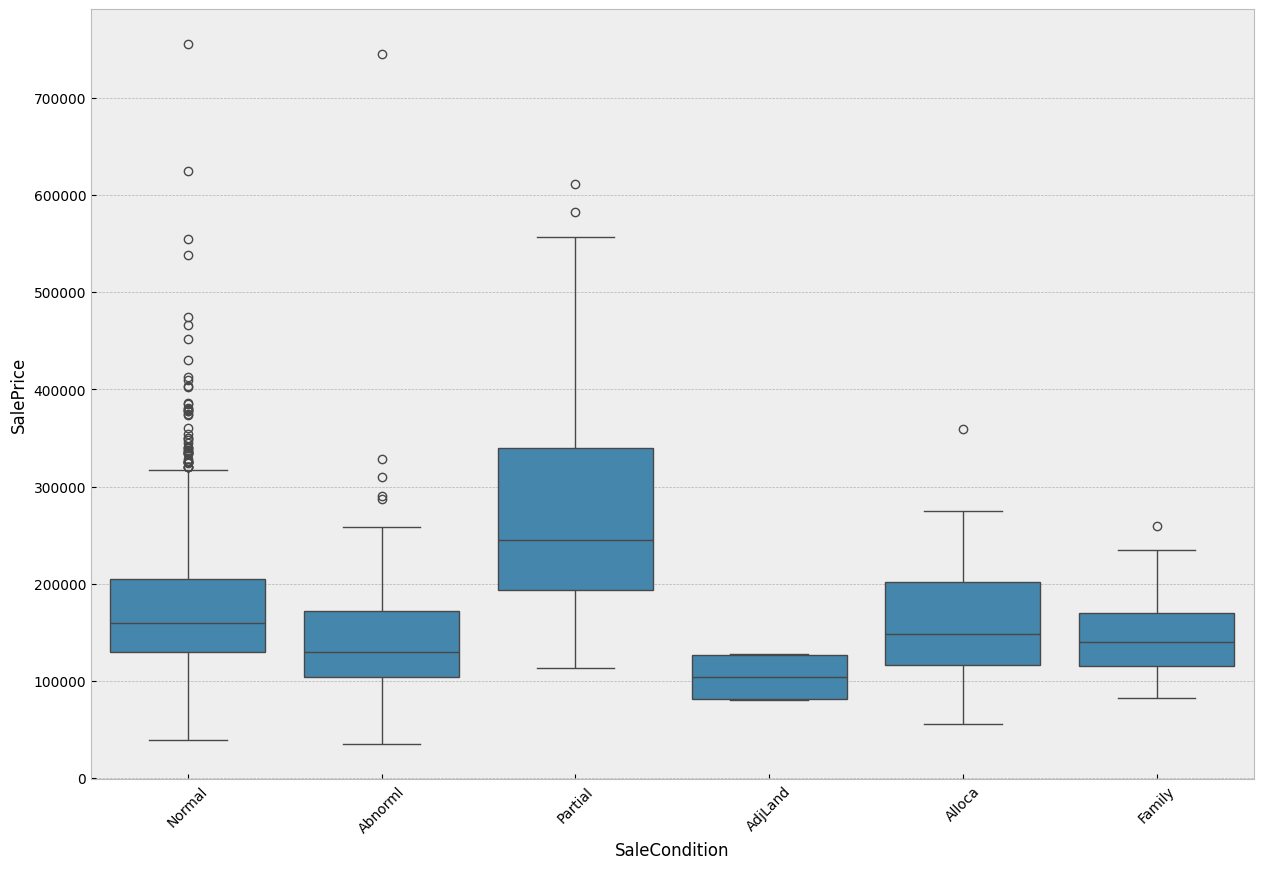

In [233]:
plt.figure(figsize = (15, 10))
ax = sns.boxplot(x='SaleCondition', y='SalePrice', data=df_categ)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

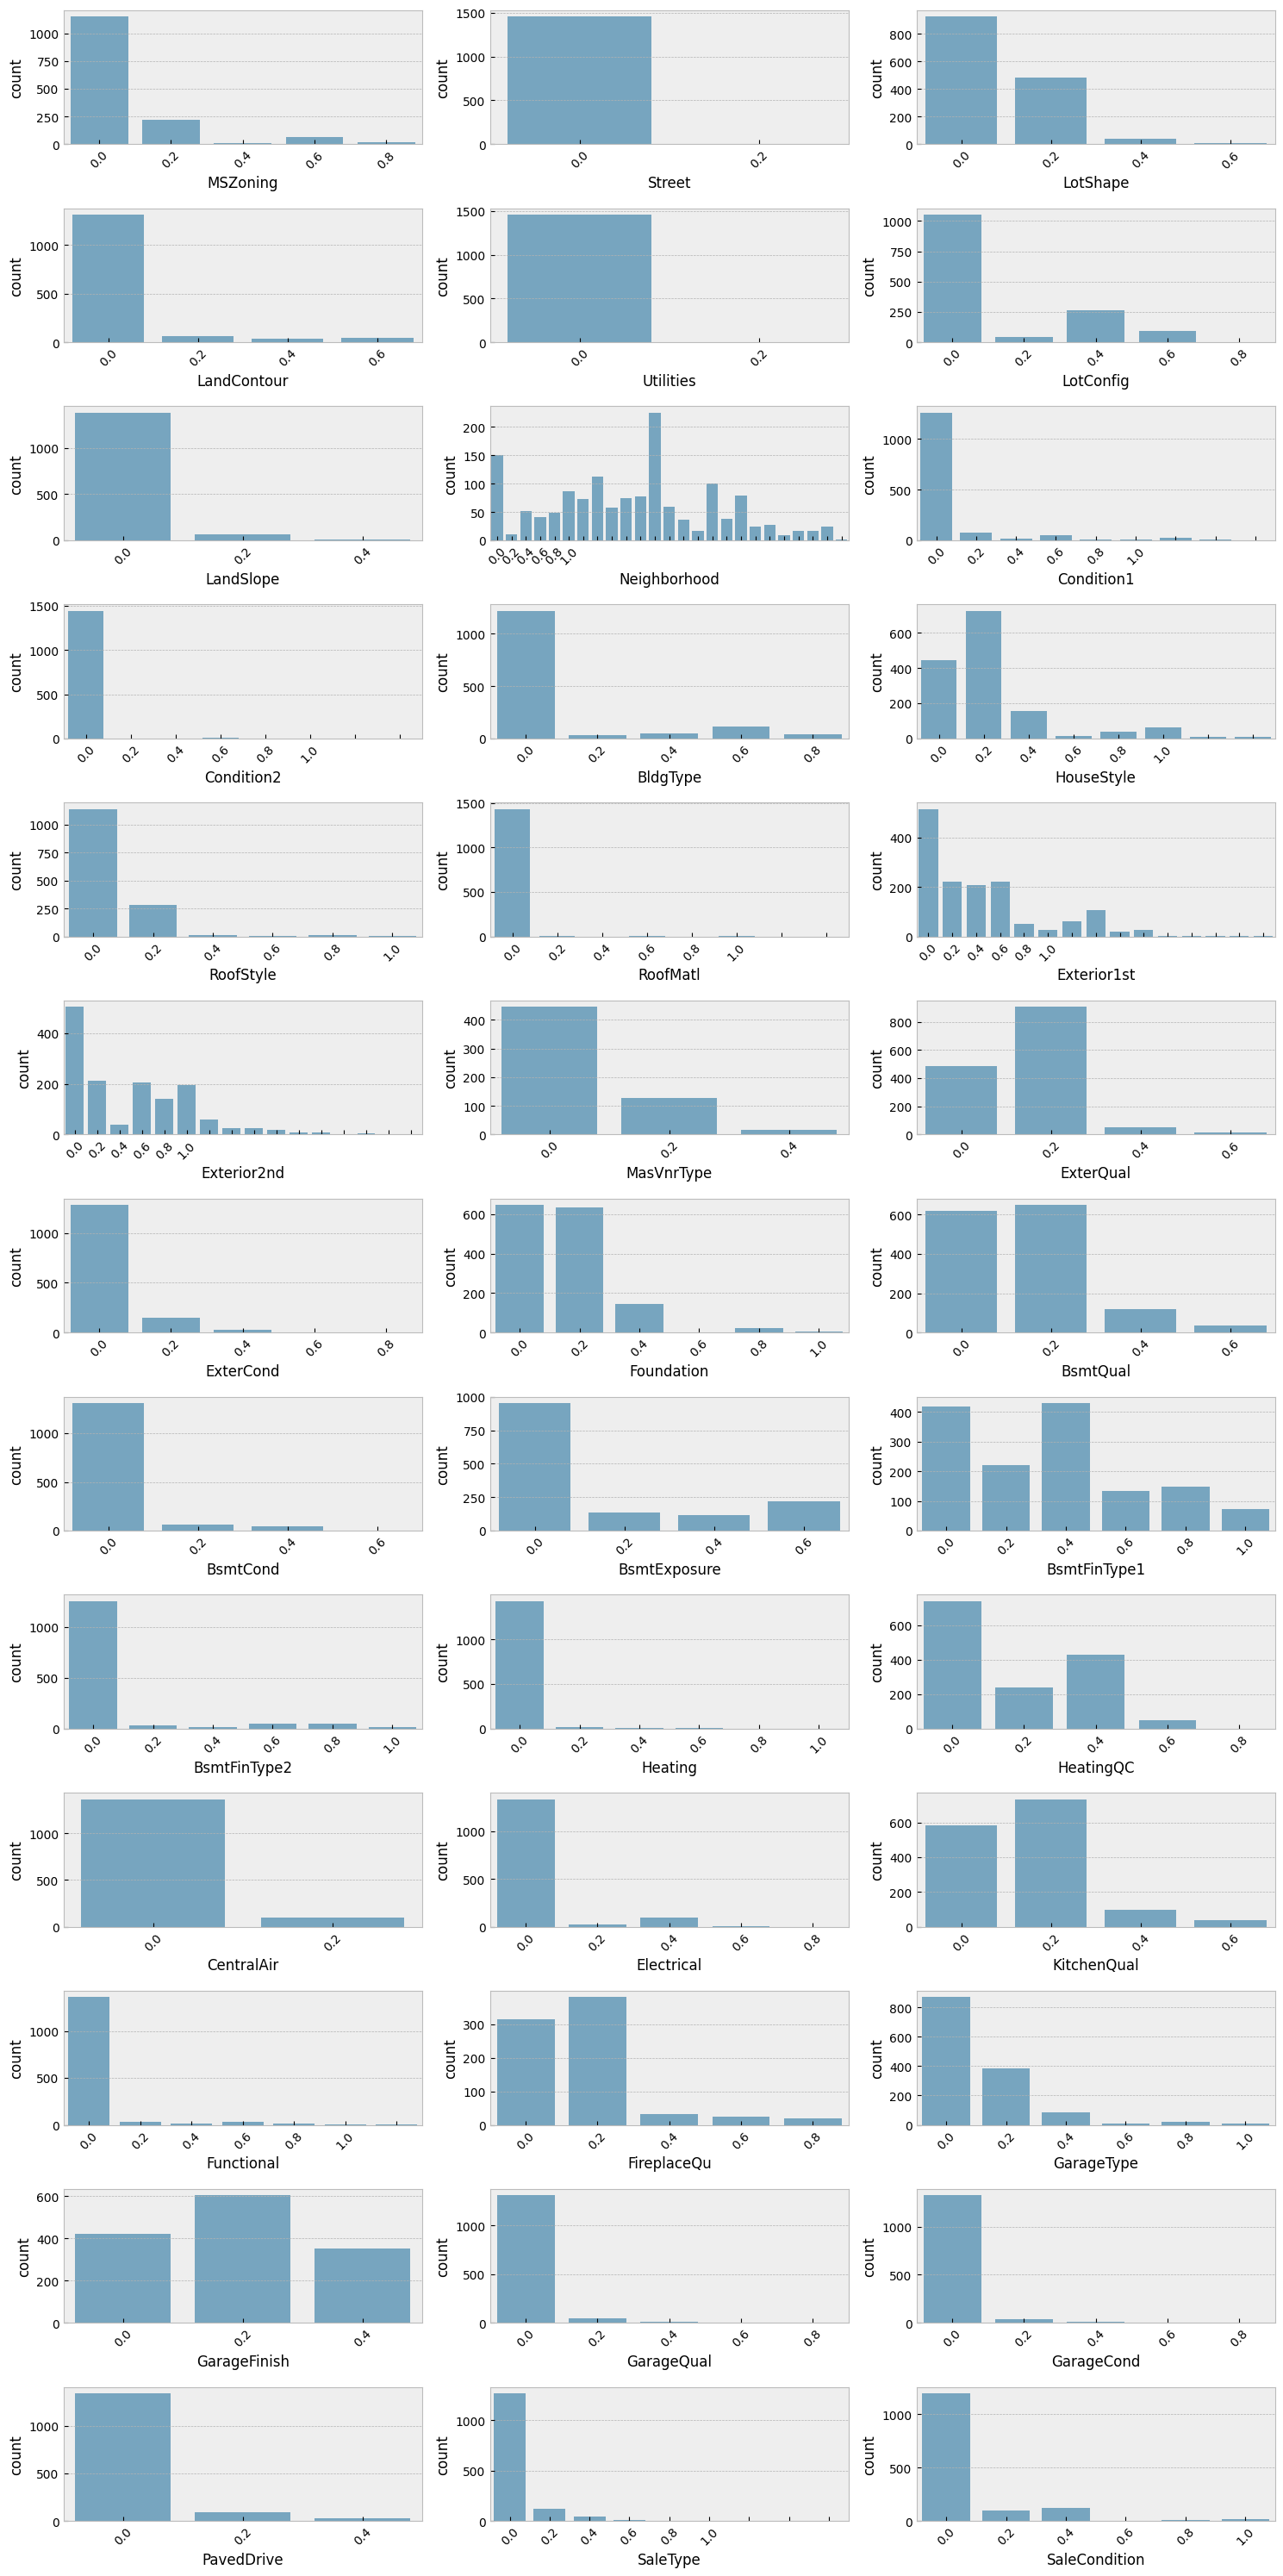

In [234]:
fig, axes = plt.subplots(round(len(df_not_num.columns) / 3), 3, figsize=(15, 30))

for i, ax in enumerate(fig.axes):
    if i < len(df_not_num.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=df_not_num.columns[i], alpha=0.7, data=df_not_num, ax=ax)

fig.tight_layout()

In [247]:
data = df[features_to_analyse]
data

,MasVnrArea,BsmtFinSF1,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea,SalePrice
0,196.0,706,856,856,854,1710,2,8,2,548,208500
1,0.0,978,1262,1262,0,1262,2,6,2,460,181500
2,162.0,486,920,920,866,1786,2,6,2,608,223500
3,0.0,216,756,961,756,1717,1,7,3,642,140000
4,350.0,655,1145,1145,1053,2198,2,9,3,836,250000
...,...,...,...,...,...,...,...,...,...,...,...
1455,0.0,0,953,953,694,1647,2,7,2,460,175000
1456,119.0,790,1542,2073,0,2073,2,7,2,500,210000
1457,0.0,275,1152,1188,1152,2340,2,9,1,252,266500
1458,0.0,49,1078,1078,0,1078,1,5,1,240,142125


In [248]:
y = data['SalePrice']
X = data.drop('SalePrice',axis = 1)

In [250]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

XGBoost

In [271]:
model = XGBRegressor(objective='reg:squarederror',  # Adjust parameters as needed
                    learning_rate=0.0001,
                    n_estimators=500,
                    eval_metric='rmse')
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [272]:
y_pred = model.predict(X_test)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(mape)

29.62400655596595


LightGBM

In [278]:
clf = lgb.LGBMRegressor()
clf.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000112 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1617
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 10
[LightGBM] [Info] Start training from score 181068.330479


LGBMRegressor()

In [279]:
y_pred = clf.predict(X_test)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(mape)

0.0


In [283]:
features_to_analyse.remove('SalePrice')

['MasVnrArea',
 'BsmtFinSF1',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'GarageCars',
 'GarageArea']

In [284]:
df_test = test[features_to_analyse]

In [285]:
result = clf.predict(df_test)

In [289]:
sample_df = pd.read_csv('unzipped_data/sample_submission.csv')
sample_df.head()

,Id,SalePrice
0,1461,123869.9922
1,1462,153666.0938
2,1463,186793.7188
3,1464,192255.0781
4,1465,190314.4688


In [290]:
sample_df['SalePrice'] = result
sample_df.head()

,Id,SalePrice
0,1461,132664.873881
1,1462,161781.120866
2,1463,188697.418437
3,1464,180593.886787
4,1465,169437.671492


In [291]:
sample_df.to_csv('Sample_sub.csv')

RandomForest

In [276]:
rf = RandomForestRegressor(n_estimators=300,max_depth=10)
model = rf.fit(X_train,y_train)

In [277]:
y_pred = model.predict(X_test)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(mape)

4.7919145183772756
